In [ ]:
from google.colab import files
uploaded = files.upload()


Saving spam.csv to spam.csv


In [ ]:
# ======== [1] المكتبات ========
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# ======== [2] إعداد موارد NLTK ========
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

# ======== [3] تحميل وتنظيف البيانات ========
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df['cleaned_message'] = df['message'].apply(clean_text)

# ======== [4] TF-IDF + النماذج التقليدية ========
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_message'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# ======== [5] تدريب النماذج ========
# Logistic Regression مع GridSearch
param_grid = {'C': [0.01, 0.1, 1, 10]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, n_jobs=-1)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_

# Naive Bayes و SVM
nb_model = MultinomialNB()
svm_model = SVC()

nb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# ======== [6] تقييم النماذج ========
def eval_model(model, X_test, y_test, name):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"--- {name} ---")
    print(classification_report(y_test, preds))
    return acc

nb_acc = eval_model(nb_model, X_test, y_test, "Naive Bayes")
lr_acc = eval_model(best_lr, X_test, y_test, "Logistic Regression (GridSearch)")
svm_acc = eval_model(svm_model, X_test, y_test, "SVM")

# ======== [7] النتائج النهائية ========
print(f"\nFinal Accuracy Results:")
print(f"Naive Bayes Accuracy: {nb_acc:.4f}")
print(f"Logistic Regression Accuracy (GridSearch): {lr_acc:.4f}")
print(f"SVM Accuracy: {svm_acc:.4f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       0.99      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115

--- Logistic Regression (GridSearch) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.86      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

--- SVM ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.98      0.83      0.90       150

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
w

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score

def eval_model_with_metrics(model, X_test, y_test, name):
    preds = model.predict(X_test)
    # بعض النماذج تعطي احتمالات
    if hasattr(model, "predict_proba"):
        preds_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        preds_proba = model.decision_function(X_test)
        # نعمل scale بين 0 و1 لو لازم
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        preds_proba = scaler.fit_transform(preds_proba.reshape(-1,1)).ravel()
    else:
        preds_proba = preds  # لو لا يوجد، نستخدم التصنيفات مباشرة

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, preds_proba)
    cm = confusion_matrix(y_test, preds)
    print(f"--- {name} ---")
    print("Classification Report:")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(cm)
    print(f"AUC-ROC: {auc:.4f}\n")
    return acc, preds, auc, cm

# مثال استخدام للنماذج التقليدية
nb_acc, y_pred_nb, nb_auc, nb_cm = eval_model_with_metrics(nb_model, X_test_tfidf, y_test_tfidf, "Naive Bayes")
lr_acc, y_pred_lr, lr_auc, lr_cm = eval_model_with_metrics(best_lr, X_test_tfidf, y_test_tfidf, "Logistic Regression (GridSearch)")
svm_acc, y_pred_svm, svm_auc, svm_cm = eval_model_with_metrics(svm_model, X_test_tfidf, y_test_tfidf, "SVM")

# ======= بالنسبة لـ LSTM =======
from sklearn.metrics import roc_auc_score, confusion_matrix

y_pred_prob_lstm = model.predict(X_test_lstm)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int).reshape(-1)
lstm_auc = roc_auc_score(y_test_lstm, y_pred_prob_lstm)
lstm_cm = confusion_matrix(y_test_lstm, y_pred_lstm)

print("--- LSTM ---")
print("Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm))
print("Confusion Matrix:")
print(lstm_cm)
print(f"AUC-ROC: {lstm_auc:.4f}\n")


--- Naive Bayes ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       0.99      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[964   1]
 [ 31 119]]
AUC-ROC: 0.9791

--- Logistic Regression (GridSearch) ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.86      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[962   3]
 [ 21 129]]
AUC-ROC: 0.9861

--- SVM ---
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00

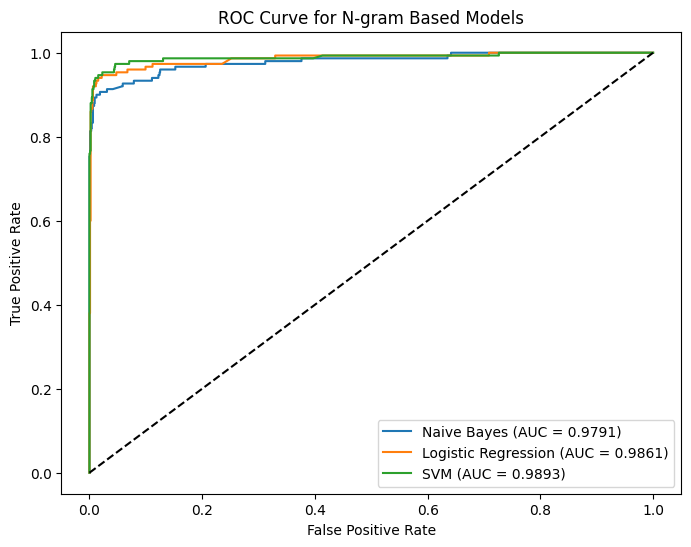

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

# رسم ROC
plt.figure(figsize=(8,6))

# Naive Bayes: احتمالات
nb_probs = nb_model.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, nb_probs, "Naive Bayes")

# Logistic Regression: احتمالات
lr_probs = best_lr.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, lr_probs, "Logistic Regression")

# SVM: استخدام decision_function وتحويلها إلى [0,1]
svm_scores = svm_model.decision_function(X_test)
svm_probs = MinMaxScaler().fit_transform(svm_scores.reshape(-1,1)).ravel()
plot_roc_curve(y_test, svm_probs, "SVM")

# إعدادات الشكل
plt.plot([0,1], [0,1], 'k--')  # خط الأداء العشوائي
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for N-gram Based Models')
plt.legend(loc='lower right')
plt.show()
